In [1]:
import pandas as pd
# import numpy as np
# import pandas as pd
import seaborn as sns
import geopandas as gpd
# import scipy.stats as stats
# import matplotlib.pyplot as plt
from src import *

In [2]:
# def create_composite_feature(dataframe, feature_list, new_feature_name, drop_features=False):
#     """
#     Create a composite feature from a list of features.
#     
#     Parameters
#     ----------
#     dataframe : pandas.DataFrame
#         The dataframe containing the features.
#     feature_list : list
#         The list of features to combine.
#     new_feature_name : str
#         The name of the new feature.
#     drop_features : bool, default False
#         Whether to drop the features used to create the new feature.
#         
#     Returns
#     -------
#     dataframe : pandas.DataFrame
#         The dataframe with the new feature added.
#     """    
#     dataframe[new_feature_name] = dataframe[feature_list].mean(axis=1)
#     if drop_features:
#         dataframe.drop(columns=feature_list, inplace=True)
#     return dataframe
# 
# 
# def create_change_features(dataframe, drop_before_after=False):
#     """
#     Create change features from before and after features.
#     
#     Parameters
#     ----------
#     dataframe : pandas.DataFrame
#         The dataframe containing the features.
#     drop_before_after : bool, default False
#         Whether to drop the before and after features.
#         
#     Returns
#     -------
#     dataframe : pandas.DataFrame
#         The dataframe with the change features added.
#         
#     Notes
#     -----
#     The change features are created by subtracting the before feature from the after feature.
#     
#     The change features are inserted after the after feature.
#     
#     Examples
#     --------
#     >>> import pandas as pd
#     >>> df = pd.DataFrame({'a_before': [1, 2, 3],
#                            'a_after': [4, 5, 6],
#                            'b_before': [7, 8, 9],
#                            'b_after': [10, 11, 12]})
#     >>> df = create_change_features(df)
#     """
#     dataframe = dataframe.copy()
#     
#     for col in dataframe.columns:
#         
#         if col.endswith('_before') or col.endswith('_after'):
#             base_col = col.rsplit('_', 1)[0]
#             before_col = base_col + '_before'
#             after_col = base_col + '_after'
#             
#             if before_col in dataframe.columns and after_col in dataframe.columns:
#                 change_col = base_col + '_change'
#                 dataframe[change_col] = dataframe[after_col] - dataframe[before_col]
#                 change_col_index = max(dataframe.columns.get_loc(before_col), dataframe.columns.get_loc(after_col)) + 1
#                 change_col_data = dataframe[change_col]
#                 dataframe.drop(columns=[change_col], inplace=True)
#                 dataframe.insert(change_col_index, change_col, change_col_data)
#                 
#                 if drop_before_after:
#                     dataframe.drop(columns=[before_col, after_col], inplace=True)
#                     
#     return dataframe
# 
# 
# # def create_intervention_features(dataframe):
# #     dataframe = dataframe.copy()
# # 
# #     for col in dataframe.columns:
# # 
# #         if col.startswith('trained') or col.startswith('adopted'):
# #             intervention_col = col.split('_', 1)[1]
# #             trained_col = 'trained_' + intervention_col
# #             adopted_col = 'adopted_' + intervention_col
# #             
# #             if trained_col in dataframe.columns and adopted_col in dataframe.columns:
# #                 # 

In [3]:
survey = pd.read_excel('../data/raw/NARIG_Survey.xlsx', usecols='A:EG')
column_names = pd.read_json('../data/processed/json/column_names.json', typ='series')

kenya = gpd.read_file('../data/processed/geojson/kenya.geojson')
counties = gpd.read_file('../data/processed/geojson/kenya_counties.geojson')
sub_counties = gpd.read_file('../data/processed/geojson/kenya_sub_counties.geojson')
wards = gpd.read_file('../data/processed/geojson/kenya_wards.geojson')
narig_wards = gpd.read_file('../data/processed/geojson/narig_wards.geojson')
kenya.crs = counties.crs = sub_counties.crs = wards.crs = narig_wards.crs = 'EPSG:4326'
makueni_county = counties[counties['county'] == 'Makueni']
makueni_sub_counties = sub_counties[sub_counties['county'] == 'Makueni']
makueni_wards = wards[wards['county'] == 'Makueni']

survey.rename(columns=column_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

# reverse_map = {v: k for k, v in ordinal_map.items()}

survey.replace(replace_map, inplace=True)
# survey.replace(ordinal_map, inplace=True)

survey = makueni_wards.merge(survey, on='ward', how='right')

survey['age'] = survey['age'].replace(0, np.nan)
survey['gender'] = survey['gender'].str.split().str[-1]

orig_col_order = list(survey.columns)

# fig, ax = plt.subplots(1, 2, figsize=(30, 15))
# sns.heatmap(survey.set_index('value_chain').sort_index().isnull(), cbar=False, ax=ax[0])

demographic_cols = survey.columns[:12].tolist()
attitude_cols = survey.columns[12:20].tolist()
knowledge_cols = survey.columns[20:25].tolist()
practice_cols = survey.columns[25:30].tolist()
# vc_performance_cols = survey.columns[30:-6].tolist()
performance_cols = survey.columns[-6:].tolist()

value_chains = list(survey['value_chain'].unique())

narig_dfs = {vc: survey[survey['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    v.dropna(axis=0, inplace=True)
    # v = create_composite_feature(v, attitude_cols, 'farmer_attitudes')
    # v = create_composite_feature(v, knowledge_cols, 'farmer_knowledge')
    # v = create_composite_feature(v, practice_cols, 'farmer_practices')
    # v = create_composite_feature(v, performance_cols, 'project_performance')
    # v = engineer_change_features(v)

narig_dfs['survey_df'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['survey_df'] = narig_dfs['survey_df'][[col for col in orig_col_order if col in narig_dfs['survey_df'].columns]]

# narig_dfs['survey_df'].replace(reverse_map, inplace=True)
# numeric_cols = narig_dfs['survey_df'].select_dtypes('number').columns.tolist()
# narig_dfs['survey_df'].replace(ordinal_map, inplace=True)

# narig_dfs['survey_df'] = create_change_features(narig_dfs['survey_df'], drop_before_after=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], attitude_cols, 'farmer_attitudes', drop_features=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], knowledge_cols, 'farmer_knowledge', drop_features=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], practice_cols, 'farmer_practices', drop_features=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], performance_cols, 'project_performance', drop_features=False)

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    for col in v.select_dtypes('float').columns:
        if v[col].apply(float.is_integer).all():
            v[col] = v[col].astype(int)
    print(k)

# sns.heatmap(narig_dfs['survey_df'].set_index('value_chain').sort_index().isnull(), cbar=False, ax=ax[1])
# plt.show()

Tomato
Mango
Green gram
Indigenous chicken
survey_df


In [4]:
narig_dfs['survey_df']

,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,...,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity,project_performance
0,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,64,Secondary,30000,3,Yes,...,NaN,NaN,NaN,5,5,4,5,5,5,4.833333
1,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67,Secondary,20000,4,Yes,...,NaN,NaN,NaN,5,5,5,5,5,5,5.000000
2,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33,Primary,5000,3,No,...,NaN,NaN,NaN,5,5,5,5,5,5,5.000000
3,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,73,Primary,800,6+,No,...,NaN,NaN,NaN,5,5,4,5,5,5,4.833333
4,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71,Secondary,10000,5,Yes,...,NaN,NaN,NaN,5,5,5,5,5,5,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,85,Primary,16000,6+,No,...,Yes,Yes,Yes,4,4,4,4,4,4,4.000000
331,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,54,Primary,14000,6+,Yes,...,Yes,Yes,Yes,4,4,4,4,4,4,4.000000
332,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,60,Primary,16000,6+,Yes,...,Yes,Yes,Yes,4,4,4,4,4,4,4.000000
333,Makueni,Kibwezi East,Mtito Andei,"POLYGON ((38.23390 -2.53316, 38.23548 -2.53385...",Female,62,Primary,4500,5,No,...,Yes,Yes,Yes,5,5,5,5,5,5,5.000000


,Ward,Sample,Returned,Percentage
0,Mtito Andei,119,122,102.52%
1,Thange,113,77,68.14%
2,Waia/Kako,99,77,77.78%
3,Tulimani,63,59,93.65%
4,Total,394,335,85.03%


,Ward,Type,Count
0,Mtito Andei,Sample,119
1,Thange,Sample,113
2,Waia/Kako,Sample,99
3,Tulimani,Sample,63
4,Mtito Andei,Returned,122
5,Thange,Returned,77
6,Waia/Kako,Returned,77
7,Tulimani,Returned,59


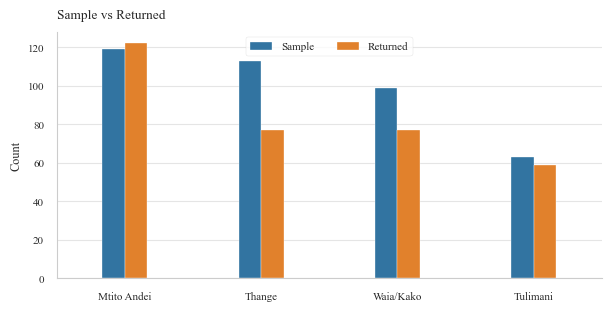

In [5]:
 # Value count ward
ward_counts = pd.DataFrame({'Ward': ['Mtito Andei', 'Thange', 'Waia/Kako', 'Tulimani'],
                            'Sample': [119, 113, 99, 63]})
ward_counts['Returned'] = narig_dfs['survey_df'].ward.value_counts().values
ward_counts.set_index('Ward', inplace=True)
ward_counts.loc['Total'] = ward_counts.sum()

ward_counts['Percentage'] = ward_counts['Returned'] / ward_counts['Sample'] * 100
ward_counts['Percentage'] = ward_counts['Percentage'].round(2)
ward_counts['Percentage'] = ward_counts['Percentage'].astype(str) + '%'
# Add total row

ward_counts.reset_index(inplace=True)
display(ward_counts)

# Melt the dataframe
ward_counts_melted = pd.melt(ward_counts.drop(4, axis=0), id_vars='Ward', value_vars=['Sample', 'Returned'], var_name='Type', value_name='Count')
display(ward_counts_melted)

# Bar chart comparing Sample vs Returned (staggered)
fig, ax = plt.subplots(figsize=(6, 3))
# sns.barplot(data=ward_counts_melted, x='Ward', y='Count', hue='Type', palette=['gray', 'navy'], ax=ax)
sns.barplot(data=ward_counts_melted, x='Ward', y='Count', hue='Type', width=0.33, ax=ax)
ax.set_title('Sample vs Returned', y=1.02, loc='left')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.legend(loc='upper center', ncol=2)
sns.despine()
plt.show()

,count,mean,std,min,25%,50%,75%,max
age,335.0,52.244776,13.656602,22.0,42.0,53.0,63.0,85.0


C:\Users\Admin\AppData\Local\Temp\ipykernel_18328\2450706655.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)


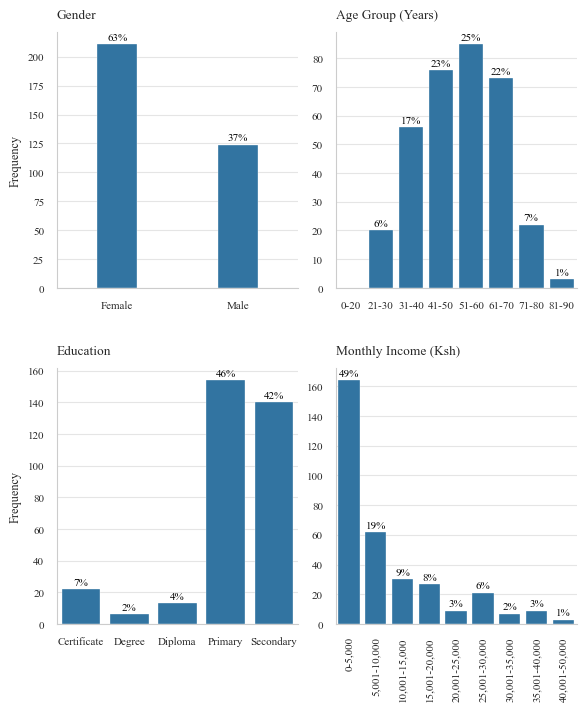

C:\Users\Admin\AppData\Local\Temp\ipykernel_18328\2450706655.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)


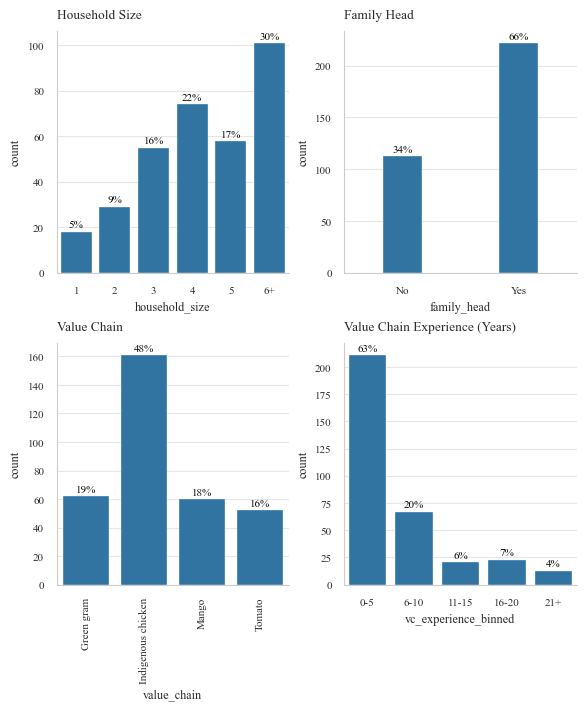

In [6]:
display(narig_dfs['survey_df'][['age']].describe().T)

# Create a new age column with the age groups
narig_dfs['survey_df']['age_group'] = pd.cut(narig_dfs['survey_df']['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90], labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])

# Create a new income column with the income groups
narig_dfs['survey_df']['income_group'] = pd.cut(narig_dfs['survey_df']['monthly_income'], bins=[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 50000], labels=['0-5,000', '5,001-10,000', '10,001-15,000', '15,001-20,000', '20,001-25,000', '25,001-30,000', '30,001-35,000', '35,001-40,000', '40,001-50,000'])

# Create a new vc_experience column with the vc_experience groups
narig_dfs['survey_df']['vc_experience_binned'] = pd.cut(narig_dfs['survey_df']['vc_experience'], bins=[0, 5, 10, 15, 20, np.inf], labels=['0-5', '6-10', '11-15', '16-20', '21+'])

# Plot age groups
fig, ax = plt.subplots(2, 2, figsize=(5.75, 7), gridspec_kw={'hspace': 0.1})

sns.countplot(data=narig_dfs['survey_df'], x='gender', width=0.33, ax=ax[0,0])
sns.countplot(data=narig_dfs['survey_df'], x='age_group', ax=ax[0,1])
sns.countplot(data=narig_dfs['survey_df'], x='education', ax=ax[1,0])
sns.countplot(data=narig_dfs['survey_df'], x='income_group', ax=ax[1,1])

# Annotate the plots with percentages
for i in range(2):
    for j in range(2):
        for p in ax[i,j].patches:
            ax[i,j].annotate(f"{p.get_height() / narig_dfs['survey_df'].shape[0] * 100:.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
            
ax[0,0].set_title('Gender', y=1.02, loc='left')
ax[0,1].set_title('Age Group (Years)', y=1.02, loc='left')
ax[1,0].set_title('Education', y=1.02, loc='left')
ax[1,1].set_title('Monthly Income (Ksh)', y=1.02, loc='left')

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('')
ax[0,0].set_ylabel('Frequency')
ax[0,1].set_ylabel('')
ax[1,0].set_ylabel('Frequency')
ax[1,1].set_ylabel('')

# ax[0].set_title('Gender', y=1.02, loc='left')
# ax[1].set_title('Age Group', y=1.02, loc='left')
# ax[2].set_title('Education', y=1.02, loc='left')
# 
# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
# ax[2].set_xlabel('')
# 
# ax[0].set_ylabel('Count')
# ax[1].set_ylabel('')
# ax[2].set_ylabel('')

ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)

sns.despine()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(5.75, 7), gridspec_kw={'hspace': 0.1})

sns.countplot(data=narig_dfs['survey_df'], x='household_size', ax=ax[0,0])
sns.countplot(data=narig_dfs['survey_df'], x='family_head', width=0.33, ax=ax[0,1])
sns.countplot(data=narig_dfs['survey_df'], x='value_chain', ax=ax[1,0])
sns.countplot(data=narig_dfs['survey_df'], x='vc_experience_binned', ax=ax[1,1])

# Annotate the plots with percentages
for i in range(2):
    for j in range(2):
        for p in ax[i,j].patches:
            ax[i,j].annotate(f"{p.get_height() / narig_dfs['survey_df'].shape[0] * 100:.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
            
ax[0,0].set_title('Household Size', y=1.02, loc='left')
ax[0,1].set_title('Family Head', y=1.02, loc='left')
ax[1,0].set_title('Value Chain', y=1.02, loc='left')
ax[1,1].set_title('Value Chain Experience (Years)', y=1.02, loc='left')

            
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)

sns.despine()
plt.show()

,index,Question,Response
0,0,project_skepticism,5
1,1,project_skepticism,5
2,2,project_skepticism,5
3,3,project_skepticism,5
4,4,project_skepticism,5
...,...,...,...
2675,330,sustainable_technology,4
2676,331,sustainable_technology,4
2677,332,sustainable_technology,4
2678,333,sustainable_technology,5


,index,Question,Response
0,0,project_understanding,5
1,1,project_understanding,5
2,2,project_understanding,5
3,3,project_understanding,5
4,4,project_understanding,5
...,...,...,...
1670,330,vc_product_marketing_understanding,4
1671,331,vc_product_marketing_understanding,4
1672,332,vc_product_marketing_understanding,4
1673,333,vc_product_marketing_understanding,5


,index,Question,Response
0,0,practice_mixed_farming,5
1,1,practice_mixed_farming,5
2,2,practice_mixed_farming,5
3,3,practice_mixed_farming,5
4,4,practice_mixed_farming,5
...,...,...,...
1670,330,full_time_farming,4
1671,331,full_time_farming,4
1672,332,full_time_farming,4
1673,333,full_time_farming,5


Text(0, 0.5, '')

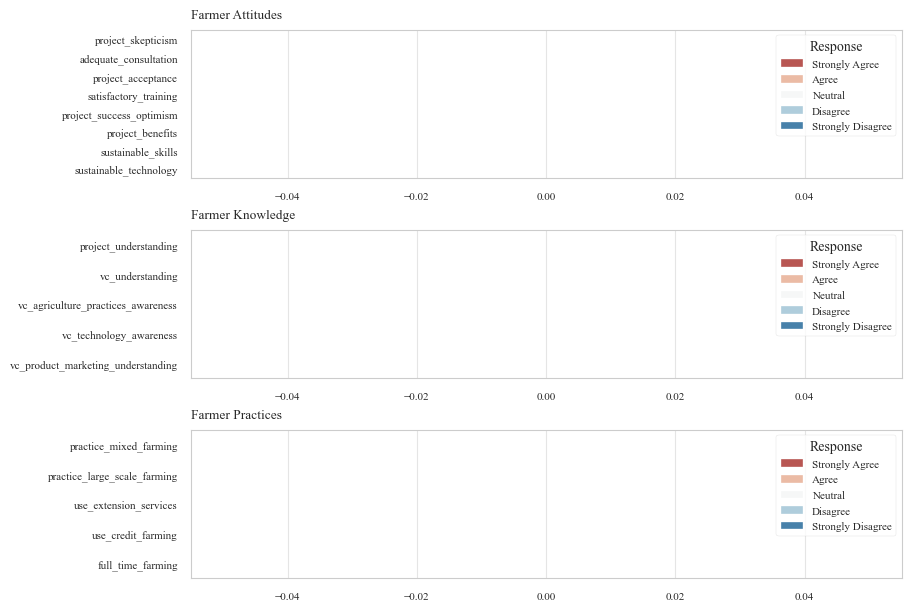

In [19]:
farmer_attitudes = narig_dfs['survey_df'][attitude_cols].reset_index()
farmer_knowledge = narig_dfs['survey_df'][knowledge_cols].reset_index()
farmer_practices = narig_dfs['survey_df'][practice_cols].reset_index()

# Melt the data to have 'Question' and 'Response' columns
farmer_attitudes_melted = pd.melt(farmer_attitudes, id_vars='index', var_name='Question', value_name='Response')
# farmer_attitudes_melted['Response'] = farmer_attitudes_melted['Response'].astype('category')
farmer_knowledge_melted = pd.melt(farmer_knowledge, id_vars='index', var_name='Question', value_name='Response')
# farmer_knowledge_melted['Response'] = farmer_knowledge_melted['Response'].astype('category')
farmer_practices_melted = pd.melt(farmer_practices, id_vars='index', var_name='Question', value_name='Response')
# farmer_practices_melted['Response'] = farmer_practices_melted['Response'].astype('category')

display(farmer_attitudes_melted, farmer_knowledge_melted, farmer_practices_melted)

palette = sns.color_palette('RdBu', 5)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), gridspec_kw={'wspace': 0.1})

sns.countplot(data=farmer_attitudes_melted, y='Question', hue='Response',
              hue_order=['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'],
              palette=palette, fill=True, dodge=True, legend=True, stat='count', ax=ax[0])
sns.countplot(data=farmer_knowledge_melted, y='Question', hue='Response',
                hue_order=['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'],
                palette=palette, fill=True, dodge=True, legend=True, stat='count', ax=ax[1])
sns.countplot(data=farmer_practices_melted, y='Question', hue='Response',
                hue_order=['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'],
                palette=palette, fill=True, dodge=True, legend=True, stat='count', ax=ax[2])

ax[0].set_title('Farmer Attitudes', y=1.02, loc='left')
ax[1].set_title('Farmer Knowledge', y=1.02, loc='left')
ax[2].set_title('Farmer Practices', y=1.02, loc='left')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')


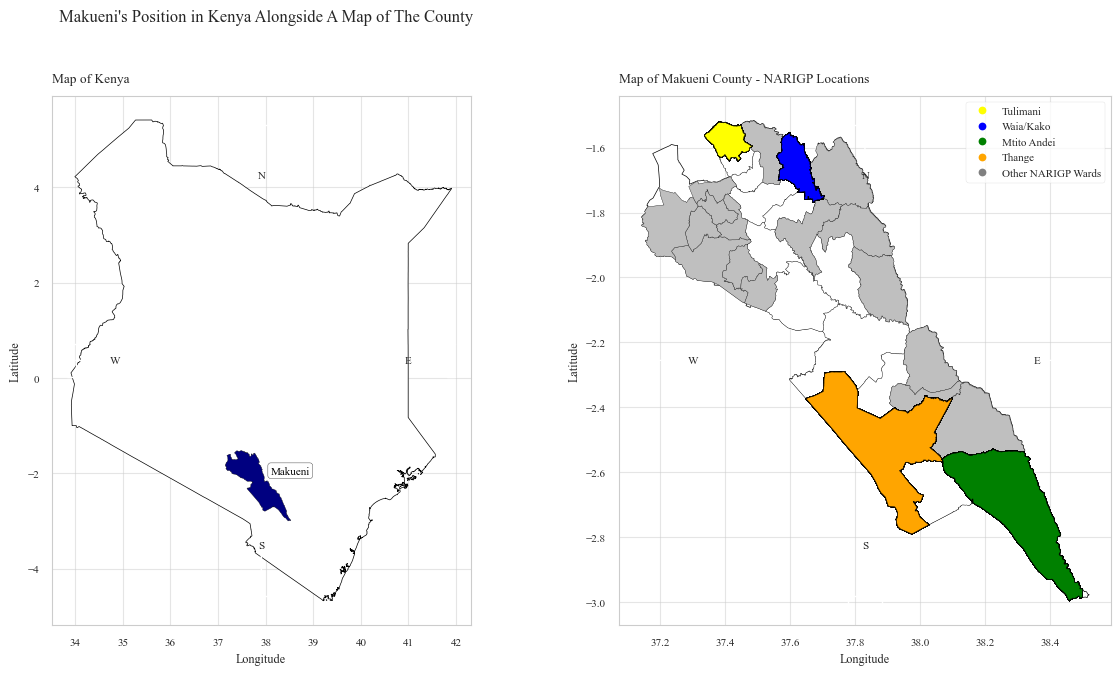

In [8]:
# Create a single figure
fig, ax = plt.subplots(1,2, figsize=(12, 6))

# Plot Kenya
kenya.plot(ax=ax[0], color='white', edgecolor='black', linewidth=0.5)
ax[0].set_title('Map of Kenya', y=1.01, loc='left')  # Set title alignment to left

# Plot Makueni County
makueni_county.plot(ax=ax[0], color='navy', edgecolor='black')

# Annotate Makueni County
centroid = makueni_county.iloc[0].geometry.centroid
annotation = ax[0].annotate('Makueni', xy=(centroid.x, centroid.y),
               xytext=(25, 5), textcoords="offset points", color='black', fontsize=8, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25))

# Plot Makueni County separately
makueni_county.plot(ax=ax[1], color='white', edgecolor='black', linewidth=0.5)
ax[1].set_title('Map of Makueni County - NARIGP Locations', y=1.01, loc='left')  # Set title alignment to left

# Plot Makueni wards
makueni_wards.plot(ax=ax[1], color='white', edgecolor='black', linewidth=0.25)
narig_wards.plot(ax=ax[1], color='gray', edgecolor='black', linewidth = 0.1, alpha=0.5)

# Annotate Makueni County in the second plot
# annotation2 = ax[1].annotate('Makueni', xy=(makueni_county.geometry.centroid.x, makueni_county.geometry.centroid.y),
#xytext=(30, 0), textcoords="offset points", color='black', fontsize=8, ha='center')

# Plot survey points
# Set colors for each ward
colors = {'Tulimani': 'yellow',
          'Waia/Kako': 'blue',
          'Mtito Andei': 'green',
          'Thange': 'orange'}

survey.plot(ax=ax[1], edgecolor='black', linewidth=0.5, color=survey['ward'].map(colors), legend=True)

# Add gray to the legend indicating NARIG locations
handles, labels = ax[1].get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='yellow', marker='o', linestyle='None'))
labels.append('Tulimani')
handles.append(plt.Line2D([], [], color='blue', marker='o', linestyle='None'))
labels.append('Waia/Kako')
handles.append(plt.Line2D([], [], color='green', marker='o', linestyle='None'))
labels.append('Mtito Andei')
handles.append(plt.Line2D([], [], color='orange', marker='o', linestyle='None'))
labels.append('Thange')
handles.append(plt.Line2D([], [], color='gray', marker='o', linestyle='None'))
labels.append('Other NARIGP Wards')
ax[1].legend(handles=handles, labels=labels)

# Add titles and labels
fig.suptitle("Makueni's Position in Kenya Alongside A Map of The County", x=0.08, y=1.1, ha='left')  # Set title alignment to left
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Add scale bar
#scalebar = gpd.GeoSeries(LineString([(0.9, 0.1), (1.1, 0.1)]), crs=kenya.crs)
#scalebar.plot(ax=ax[0], color='black', linewidth=2)

# Move legend lower
# ax[1].get_legend().set_bbox_to_anchor((0.525, 0.33))
# # ax[1].get_legend().set_title('Ward')
# # Reduce the size of the legend
# ax[1].get_legend().get_title().set_fontsize(8)
# for t in ax[1].get_legend().texts:
#     t.set_fontsize(8)

# Remove axes
# ax[0].set_axis_off()
# ax[1].set_axis_off()
# Add a compass rose
ax[0].annotate('N', xy=(0.5, 0.95), xytext=(0.5, 0.85), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
ax[0].annotate('S', xy=(0.5, 0.05), xytext=(0.5, 0.15), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
ax[0].annotate('E', xy=(0.95, 0.5), xytext=(0.85, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
ax[0].annotate('W', xy=(0.05, 0.5), xytext=(0.15, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))

ax[1].annotate('N', xy=(0.5, 0.95), xytext=(0.5, 0.85), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
ax[1].annotate('S', xy=(0.5, 0.05), xytext=(0.5, 0.15), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
ax[1].annotate('E', xy=(0.95, 0.5), xytext=(0.85, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
ax[1].annotate('W', xy=(0.05, 0.5), xytext=(0.15, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=8, arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.75', lw=1.0))
# Add a border to the figure
# fig.patch.set_edgecolor('black')

plt.show()

In [9]:
print(handles, labels)

[<matplotlib.lines.Line2D object at 0x0000019876048F50>, <matplotlib.lines.Line2D object at 0x00000198706C9590>, <matplotlib.lines.Line2D object at 0x0000019875A354D0>, <matplotlib.lines.Line2D object at 0x0000019876112CD0>, <matplotlib.lines.Line2D object at 0x0000019875A62850>] ['Tulimani', 'Waia/Kako', 'Mtito Andei', 'Thange', 'Other NARIGP Wards']


In [10]:
# narig_dfs['survey_df'][numeric_cols].hist(figsize=(9,9))
# plt.show()
# 
# 
# def filter_outliers(dataframe: pd.DataFrame, columns: list):
#     
#     for col in columns:
#         
#         mean = dataframe[col].mean()
#         std = dataframe[col].std()
#         limit = std * 3
# 
#         lower, upper = (mean - limit), (mean + limit)
# 
#         dataframe = dataframe[(dataframe[col] > lower) &
#                                    (dataframe[col] < upper)]
#         
#         return dataframe
#         
# df_outliers = filter_outliers(narig_dfs['survey_df'], numeric_cols)
# 
# df_outliers[numeric_cols].hist(figsize=(9,9))
# plt.show()
# 
# 
# # survey.hist('vc_experience')
# # plt.show()
# 
# # mean_vce = survey.vc_experience.mean()
# # print(mean_vce)
# # std_vce = survey.vc_experience.std()
# # print(std_vce)
# # limit = std_vce * 3
# # print(limit)
# # lower, upper = mean_vce - limit, mean_vce + limit
# # print(lower, ',', upper)
# 
# # survey = survey[survey['vc_experience'] < upper]
# 
# 
# # # survey['vc_experience'] = survey.vc_experience ** 1/3
# 
# # survey.hist('vc_experience')
# # plt.show()
# 
# # mean_vce = survey.vc_experience.mean()
# # print(mean_vce)
# # std_vce = survey.vc_experience.std()
# # print(std_vce)
# # limit = std_vce * 3
# # print(limit)
# # lower, upper = mean_vce - limit, mean_vce + limit
# # print(lower, ',', upper)
# 
# # survey = survey[survey['vc_experience'] > upper]
# 
# # survey.hist('vc_experience')
# # plt.show()

NameError: name 'numeric_cols' is not defined

In [ ]:
df_outliers.describe().round(2).T.map(lambda x: int(x) if x.is_integer() else x).rename(columns={'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Minimum', '25%': '25th Percentile', '50%': '50th Percentile', '75%': '75th Percentile', 'max': 'Maximum'})

In [ ]:
# Plot project_performance on the map
fig, ax = plt.subplots(figsize=(8, 4))

makueni_county.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
makueni_wards.plot(ax=ax, color='white', edgecolor='black', linewidth=0.25)
cax = fig.add_axes([1, 0.2, 0.02, 0.6])  # Reduce the width of the colorbar axes
df_outliers.plot('project_performance', legend=True, ax=ax, cax=cax)  # Add cax parameter to specify the colorbar axes

# Add title and labels
ax.set_title('Project Performance Across NARIG Wards', y=1.01, loc='left')  # Set title alignment to left

# Get unique geometries from the dataframe
unique_geometries = df_outliers.drop_duplicates(subset='geometry')

# Add annotations individually
tulimani = unique_geometries[unique_geometries['ward'] == 'Tulimani']
tulimani_centroid = tulimani.iloc[0].geometry.centroid
ax.annotate('Tulimani', xy=(tulimani_centroid.x, tulimani_centroid.y),
            xytext=(-40, 10), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

kako = unique_geometries[unique_geometries['ward'] == 'Waia/Kako']
kako_centroid = kako.iloc[0].geometry.centroid
ax.annotate('Waia/Kako', xy=(kako_centroid.x, kako_centroid.y),
            xytext=(30, 27.5), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

mtito = unique_geometries[unique_geometries['ward'] == 'Mtito Andei']
mtito_centroid = mtito.iloc[0].geometry.centroid
ax.annotate('Mtito Andei', xy=(mtito_centroid.x, mtito_centroid.y),
            xytext=(-30, -30), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

thange = unique_geometries[unique_geometries['ward'] == 'Thange']
thange_centroid = thange.iloc[0].geometry.centroid
ax.annotate('Thange', xy=(thange_centroid.x, thange_centroid.y),
            xytext=(-45, -15), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

# Remove axes
ax.set_axis_off()

plt.show()

In [ ]:
# # Cuberoot
# for col in df_outliers.select_dtypes('number').columns:
#     df_outliers[col] = df_outliers[col] ** 1/3

In [ ]:
corr = df_outliers[numeric_cols + ['farmer_attitudes', 'farmer_knowledge', 'farmer_practices', 'project_performance']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Sort the correlation matrix by project_performance (both axes)
corr = corr.sort_values(by='project_performance', ascending=False); corr = corr[corr.index]

sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', cbar=False, ax=ax[0])
ax[0].set_title('Correlation Matrix', y=1.01, loc='left')
sns.barplot(y=corr['project_performance'].sort_values(ascending=False).values, x=corr['project_performance'].sort_values(ascending=False).index, hue=corr['project_performance'], orient='v', palette=sns.color_palette('Blues', len(corr.columns)), width = 0.5, legend=False, ax=ax[1])
for i, v in enumerate(corr['project_performance'].sort_values(ascending=False).values):
    if v > 0:
        ax[1].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)
    else:
        ax[1].text(i, v - 0.01, f"{v:.2f}", ha='center', va='top', fontsize=8)

ax[1].set_xlabel('')
ax[1].set_title('Correlation with Project Performance', y=1.01, loc='left')
ax[1].xaxis.set_tick_params(rotation=90)

ax[0].tick_params(axis='x', which='both', bottom=False)
ax[1].tick_params(axis='x', which='both', bottom=False)

sns.despine()

plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))

sns.regplot(data=df_outliers, x='farmer_attitudes', y='project_performance', ax=ax[0], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='farmer_knowledge', y='project_performance', ax=ax[1], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='farmer_practices', y='project_performance', ax=ax[2], scatter_kws={'alpha': 0.5}, logx=False, ci=None)


ax[0].set_title('Farmer Attitudes vs Project Performance', y=1.02, loc='left')
ax[1].set_title('Farmer Knowledge vs Project Performance', y=1.02, loc='left')
ax[2].set_title('Farmer Practices vs Project Performance', y=1.02, loc='left')

ax[0].set_xlabel('Farmer Attitudes')
ax[1].set_xlabel('Farmer Knowledge')
ax[2].set_xlabel('Farmer Practices')

ax[0].set_ylabel('Project Performance')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

sns.despine()

plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))

sns.regplot(data=df_outliers, x='age', y='project_performance', ax=ax[0], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='monthly_income', y='project_performance', ax=ax[1], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='vc_experience', y='project_performance', ax=ax[2], scatter_kws={'alpha': 0.5}, logx=False, ci=None)

ax[0].set_title('Age vs Project Performance', y=1.02, loc='left')
ax[1].set_title('Monthly Income vs Project Performance', y=1.02, loc='left')
ax[2].set_title('Value Chain Experience vs Project Performance', y=1.02, loc='left')

ax[0].set_xlabel('Age')
ax[1].set_xlabel('Monthly Income')
ax[2].set_xlabel('Value Chain Experience')

ax[0].set_ylabel('Project Performance')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

sns.despine()

plt.show()

In [ ]:
# Create a figure with boxplots for demographic data against project_performance
fig, ax = plt.subplots(2, 2, figsize=(9, 6), sharey=True)

sns.boxplot(data=df_outliers, x='value_chain', y='project_performance', width=0.25, ax=ax[0,0])
sns.boxplot(data=df_outliers, x='education', y='project_performance', width=0.25, ax=ax[0,1])
sns.boxplot(data=df_outliers, x='gender', y='project_performance', width=0.1, ax=ax[1,0])
sns.boxplot(data=df_outliers, x='family_head', y='project_performance', width=0.1, ax=ax[1,1])

ax[0,0].set_title('Value Chain vs Project Performance', y=1.02, loc='left')
ax[0,1].set_title('Education vs Project Performance', y=1.02, loc='left')
ax